# Overview
From the Kaggle web site (https://www.kaggle.com/datasets) download the Suicide Rates Overview 1985 to 2016 dataset. This dataset has 12 features and 27820 data points. In this assignment we would like to develop a machine learned model to predict, given some feature vectors, if the outcome would be suicide or not, as a binary dependent variable. The binary categories could be {"low suicide rate", "high suicide rate"}. (Note that a different approach could seek to generate a numerical value by solving a regression problem.)


A machine learning solution would require us to pre-process the dataset and prepare/design our experimentation.


Load the dataset in your model development framework (Jupyter notebook) and examine the features. Note that the Kaggle website also has histograms that you can inspect. However, you might want to look at the data grouped by some other features. For example, what does the 'number of suicides / 100k' histogram look like from country to country?


To answer the following questions, you have to think thoroughly, and possibly attempt some pilot experiments. There is no one right or wrong answer to some questions below, but you will always need to work from the data to build a convincing argument for your audience.

### 1. [10 pts] Due to the severity of this real-world crisis, what information would be the most important to "machine learn"? Can it be learned? (Note that this is asking you to define the big-picture question that we want to answer from this dataset. This is not asking you to conjecture which feature is going to turn out being important.

#### 1. Answer

In my opinion the most important thing to determine with the dataset is what causes suicides.  It seems a problem people struggle to understand, therefore teaching a machine to understand it wouldn't be possible.  Maybe we could teach a machine to observe for causes of suicide.  I think a machine can be taught to observe for causes of suicide, and how likely they are to occur in a population or an individual.  It seems unlikely that we will be able to do that with this dataset.  The data has too few features-- `year` and `generation` are tightly correlated, as are `year` and `country-year`. 

In [1]:
### 1. Experiments
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
import numpy as np
import pandas as pd
# Visualizations
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# Locate and load the data file
df = pd.read_csv('./datasets/master.csv', thousands=',')

# Sanity
print(f'#rows={len(df)} #columns={len(df.columns)}')
df.head()

#rows=27820 #columns=12


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,2156624900,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,2156624900,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,2156624900,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,2156624900,796,Boomers


### 2. [10 pts] Explain in detail how one should set up the problem. Would it be a regression or a classification problem? Is any unsupervised approach, to look for patterns, worthwhile?

#### 2. Answer
Starting with the last question, "is any unsupervised approach worthwhile," considering this dataset no.  The dataset has labeled features.  It might be useful do a comparison of omitting labels and testing whether an unsupervised approach finds possible relations.

To address the larger question-- we could use a Decision Tree, or by extension a random forest; but this is also a regression problem since we want to determine where on a numeric scale the rate of suicides per 100,000 persons will trend.  To setup the problem we will need to normalize the numeric features `HDI for year`, `gdp_for_year($)`, `gdp_per_capita ($)`, `population`, `suicides_no`, `year` (we could have standardized them too); map the ordinal features `age` and `generation`; and encode the nominal features `country` and `sex`.  

We will drop the feature `country-year` since it is captured in the dataset.  We could have chosen to drop `country` and `year` however I like that year is numeric, and perhaps there are relations between the year and different countries.  Additionally, I will train two version of the model, one including `suicides_no` and `population` and one without.  These two features in combination have a correlation coefficient of 1 with the target.  That doesn't answer the question _I_ am curious about, which is about what in a population makes them susceptible to suicide.

### 3. [20 pts] What should be the dependent variable?

#### 3. Answer
According to the dataset page on Kaggle, the dataset intends to collate information on "suicide rates by cohort."  This means the `suicides/100k pop` is the target, which makes sense.  We will explore it in the next question, but that may mean we can remove `suicides_no` or `population` features for training deployment.


### 4. [20 pts] Find some strong correlations between the independent variables and the dependent variable you decided and use them to rank the independent variables.

#### 4. Answer

Finding correlations when there are missing or NaN values would be in error since it would skew the data.  Granted, I will skew the data by adding the mean value if the feature is a numeric type.  After processing the data I will use Pandas `DataFrame.corrwith` to find correlation with the target column `suicides/100k pop`, which I will rename to `suicides per 100k pop`.  


Here is a summary of the steps I took.
- Drop `country-year` since it is accounted for with other features.
- Remove ($), parens and `/` from feature names. Note `gdp_for_year ($)` gave me trouble so I had to do it in an irritating way. 
- Check for duplicates. _None found._
- Check for null values. _None found._
- Check for NaN. _Only found NaN values in the `HDI for year` features. `DataFrame.describe() shows 8364 non-NaN values, which means almost more than 2x that number are NaN.  Perhaps I should drop this features, but there are so few already that I am choosing to keep it._
- Fill NaN values of `HDI for year`with the mean of `HDI for year`.
- Scale the numeric features using normalization
- Use Pandas to check for correlation of each feature with the target

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


def fix_data_before_numeric_or_ordinal_changes(df, printer=True):
    if printer: print(df.dtypes)
    
    # df = df.drop(columns=['country-year', 'population', 'suicides_no'])
    df = df.drop(columns=['suicides_no'])
    df = df.rename(columns={'gdp_per_capita ($)': 'gdp_per_capita', 'suicides/100k pop': 'suicides per 100k pop'})
    
    
    for c in df.columns:
        if 'gdp_for_year' in c:
            new_column_name = c.replace('($)','').strip()
            df = df.rename(columns={c: new_column_name})
            if printer: print(new_column_name)
    
    if printer: print(df.columns)
    
    # Check for duplicates, this adds a new column to the dataset
    if printer: print(f'Count of duplicates: {len(df.duplicated())}')
    
    if printer: print('\n\n\n')
    if printer: print(df.isnull().any())
    
    
    if printer: print('\n\n\n')
    if printer: print(f'See that there is only one column with NaN values:\n{df.isna().any()}')
    if printer: print(f'"HDI for year" is the only column with NaN.  Let\'s compare how many NaN {df["HDI for year"].isna().count()} vs {df["HDI for year"].notna().count()} non-NaN of a total of {len(df["HDI for year"])} samples')
    if printer: print(df["HDI for year"].describe())
    if printer: print(f'This is reporting specious results.  DataFrame.describe() is showing 8364 non-NaN values.  Let\'s fill NaN with the means and see what that changes.')
    
    # Replace NaN values, or leave it as is otherwise
    mean_value = df['HDI for year'].mean()
    df['HDI for year'] = df['HDI for year'].fillna(mean_value)
    # This shows that there are no longer any missing values
    if printer: print(f'\n\nSee, no more missing values.{df.isna().any()}')
    
    
    if printer: print('\n\n\n')
    ## Using the method described in the module notebook, check unique values by column
    for col in df.columns:
        if df[col].dtype == object:
            if printer: print(col, df[col].unique())
    return df


df4 = fix_data_before_numeric_or_ordinal_changes(df)

# Scale the numeric features
numeric_columns = list(df4.select_dtypes(exclude=['object']).columns)
sc = StandardScaler()
df4[numeric_columns] = sc.fit_transform(df4[numeric_columns])


## LabelEncoder
# Encode object types. They are all strings.  Save the labelencoders paired with the column names so we can reverse the values later
columns_to_encode = df4.select_dtypes(include='object')
for column in columns_to_encode:
    le = LabelEncoder()
    df4[column] = le.fit_transform(df4[column].astype(str))


# Use pandas to print correlation
print('\n\n\n')
labels = list(df4.columns)
feature_labels = list(df4.columns)
target_label = 'suicides per 100k pop'
feature_labels.remove(target_label)
X = df4.drop(target_label, axis=1).values
y = df4[target_label].values
print(labels, '\n',feature_labels, '\n', target_label, '\n', )
print(f'\n\n{"-"*50}\nPandas DataFrame.corrwith():\n{"-"*50}\n{df4.corrwith(df4[target_label]).sort_values()}')

country                object
year                    int64
sex                    object
age                    object
suicides_no             int64
population              int64
suicides/100k pop     float64
country-year           object
HDI for year          float64
 gdp_for_year ($)       int64
gdp_per_capita ($)      int64
generation             object
dtype: object
gdp_for_year
Index(['country', 'year', 'sex', 'age', 'population', 'suicides per 100k pop',
       'country-year', 'HDI for year', 'gdp_for_year', 'gdp_per_capita',
       'generation'],
      dtype='object')
Count of duplicates: 27820




country                  False
year                     False
sex                      False
age                      False
population               False
suicides per 100k pop    False
country-year             False
HDI for year              True
gdp_for_year             False
gdp_per_capita           False
generation               False
dtype: bool




See that there is only one co

### 5. [20 pts] Pre-process the dataset and list the major features you want to use. Note that not all features are crucial. For example, country-year variable is a derived feature and for a classifier it would not be necessary to include the year, the country and the country -year together. In fact, one must avoid adding a derived feature and the original at the same time.
List the independent features you want to use.

#### 5. Answer
My independent variables will be `generation`, `year`, `gdp_per_capita`, `gdp_for_year`, `HDI for year`, `country`, `sex`, and `age`.  I will not be using `year` or `generation` since they don't correlate with the target; and I will drop `suicides_no` and `population` since `suicides_no` /`population` = `suicides per 100k pop`.

### 6. [20 pts] Devise a classification problem and present a working prototype model. (It does not have to perform great, but it has to be functional.) Note that we will continue with this problem in the following modules.

#### 6. Answer

Since I am calling this a regression problem I will use a regressor from Scikit-Learn, `GradientBoostingRegressor`.  The documentation on `GradientBoostingRegressor` uses the Diabetes dataset, which is totally composed of numeric features.  I am using the `max_depth` of 3 since it is close to the square root of the 8 features I've chosen.

I tested the `GradientBoostingRegressor` with normalized and standardized features. Normalized features resulted in lower MAE and MSE.  I omitted printing the graphs, which could be done by setting the `plotter` flag to `True` in the second run.


Recall that in `#4` I extracted `X` and `y` for correlation.  I 

The mean absoluge error (MAE) on test set: 0.3760336481
The mean squared error (MSE) on test set: 0.4404887427


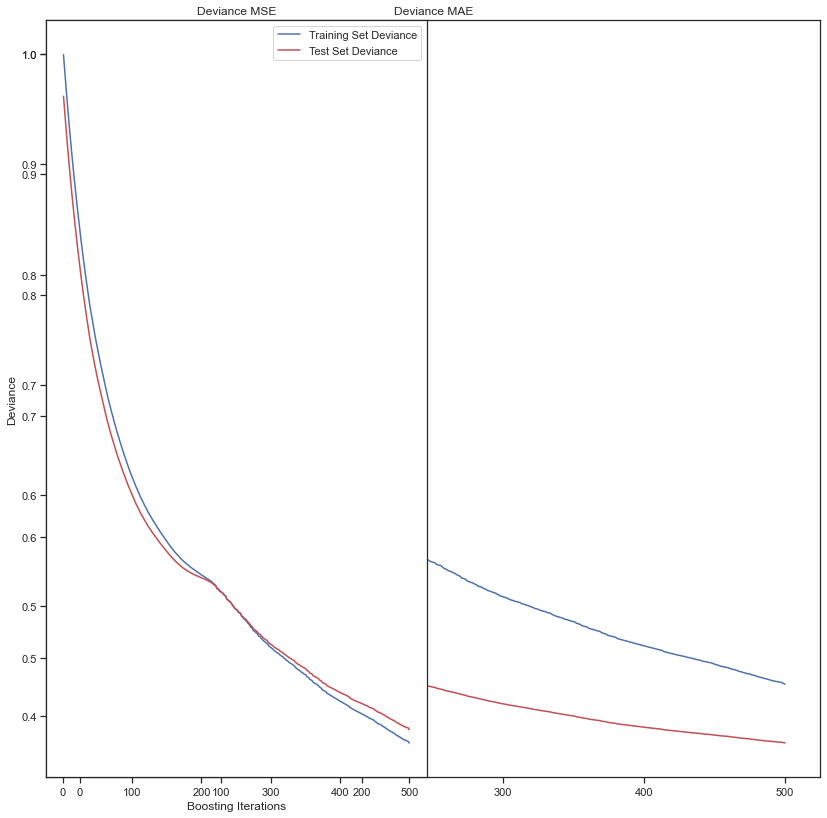

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split


def answer_q_6(X, y, clf=None, plotter=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    
    mae = mean_absolute_error(y_test, clf.predict(X_test))
    print("The mean absoluge error (MAE) on test set: {:.10f}".format(mae))
    
    mse = mean_squared_error(y_test, clf.predict(X_test))
    print("The mean squared error (MSE) on test set: {:.10f}".format(mse))
    

    if plotter:
        test_score_mae = np.zeros((params["n_estimators"],), dtype=np.float64)
        for i, y_pred in enumerate(clf.staged_predict(X_test)):
            test_score_mae[i] = mean_absolute_error(y_test, y_pred)
            
        test_score_mse = np.zeros((params["n_estimators"],), dtype=np.float64)
        for i, y_pred in enumerate(clf.staged_predict(X_test)):
            test_score_mse[i] = mean_squared_error(y_test, y_pred)
        
        fig = plt.figure(figsize=(12, 12))
        plt.subplot(1, 1, 1)
        plt.title("Deviance MAE")
        plt.plot(
            np.arange(params["n_estimators"]) + 1,
            clf.train_score_,
            "b-",
            label="Training Set Deviance",
        )
        plt.plot(
            np.arange(params["n_estimators"]) + 1, test_score_mae, "r-", label="Test Set Deviance"
        )
        
        
        plt.subplot(1, 2, 1)
        plt.title("Deviance MSE")
        plt.plot(
            np.arange(params["n_estimators"]) + 1,
            clf.train_score_,
            "b-",
            label="Training Set Deviance",
        )
        plt.plot(
            np.arange(params["n_estimators"]) + 1, test_score_mse, "r-", label="Test Set Deviance"
        )
        
        plt.legend(loc="upper right")
        plt.xlabel("Boosting Iterations")
        plt.ylabel("Deviance")
        fig.tight_layout()
        plt.show()



params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
clf = ensemble.GradientBoostingRegressor(**params)
answer_q_6(X, y, clf=clf)

The mean absoluge error (MAE) on test set: 0.0000000029
The mean squared error (MSE) on test set: 0.0000000000


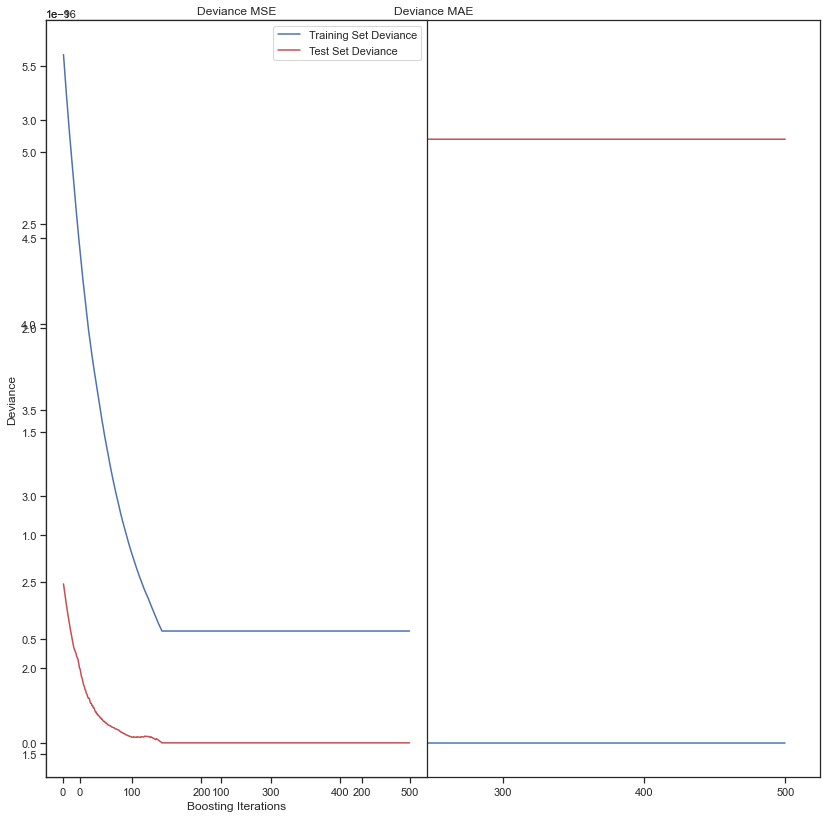

In [4]:
from sklearn.preprocessing import Normalizer

df6 = fix_data_before_numeric_or_ordinal_changes(df, printer=False)
numeric_columns = list(df6.select_dtypes(exclude=['object']).columns)
nm = Normalizer()
df6[numeric_columns] = nm.fit_transform(df6[numeric_columns])


## LabelEncoder
# Encode object types. They are all strings.  Save the labelencoders paired with the column names so we can reverse the values later
columns_to_encode = df6.select_dtypes(include='object')
encoders = dict.fromkeys(columns_to_encode)
for column in columns_to_encode:
    le = LabelEncoder()
    df6[column] = le.fit_transform(df6[column].astype(str))
    encoders[column] = le


labels = list(df6.columns)
feature_labels = list(df6.columns)
target_label = 'suicides per 100k pop'
feature_labels.remove(target_label)
## Preserve X, y 
X6 = df6.drop(target_label, axis=1).values
y6 = df6[target_label].values

clf = ensemble.GradientBoostingRegressor(**params)
answer_q_6(X6, y6, clf=clf, plotter=True)

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv('./datasets/master.csv', thousands=',')

# Drop unnecessary columns
df = df.drop(columns=["country-year"])  # Drop HDI as it has many NaNs
df = fix_data_before_numeric_or_ordinal_changes(df, printer=False)


# Encode categorical variables
columns_to_encode = ["country", "sex", "age", "generation"]
for col in columns_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


# Define features and target
X = df.drop(columns=["suicides per 100k pop"])  # Using all other columns as features
y = (df["suicides per 100k pop"] > df["suicides per 100k pop"].median()).astype(int)  # Convert suicide numbers into binary classes

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

Index(['country', 'year', 'sex', 'age', 'population', 'suicides per 100k pop',
       'HDI for year', 'gdp_for_year', 'gdp_per_capita', 'generation'],
      dtype='object')
Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      2819
           1       0.93      0.93      0.93      2745

    accuracy                           0.93      5564
   macro avg       0.93      0.93      0.93      5564
weighted avg       0.93      0.93      0.93      5564



# References
1. Raschka, Sebastian, et al. Machine Learning with PyTorch and Scikit-Learn: Develop machine learning and deep learning models with Python. Packt Publishing Ltd, 2022.
2. Guven, Erhan. Applied Machine Learning: Module 3 Notebook.  Last accessed 6 February, 2025.
3. Scikit-Learn. https://scikit-learn.org/stable/. Last accessed 6 February, 2025.